# Мультифрактальные спектры для каналов B,G,R и H из HSV

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import itertools
import math
import cv2
import os

#C помощью функции плотности
class MultifractalSpectreCapacity:
    #rs - радиусы, n_alpha - число промежутков для alpha (число изображений - уровней на 1 меньше)
    def __init__(self, rs = np.arange(2, 30), n_alpha = 6):
        self.rs = rs
        self.n_alpha = n_alpha
        
    def process(self, image):
        self.n, self.m = image.shape
        image = image.astype('float')
        alphas, F = self.calculate_spectre(image, verbose = True)
        plt.plot(alphas[:-1], F)
        plt.xlabel('alpha')
        plt.ylabel('f(alpha)')
        plt.show()
        
    def LeastSquares(self, xs, ys):
        A = np.vstack([xs, np.ones(len(xs))]).T
        k, b = np.linalg.lstsq(A, ys)[0]
        return k

    def capacity_dim(self, img):
        xs, ys = [], []
        epss, k = [100], 2 #начальный eps и k
        while epss[-1] > 2*k: #пока размер ячейки больше 2*k, уменьшаем eps в k раз
            epss.append(epss[-1] // k)
        for eps in epss:
            N = 0
            for c1, c2 in itertools.product(range(self.n // eps), range(self.m // eps)):
                pos1, pos2 = c1*eps, c2*eps
                if 0 in img[pos1:pos1 + eps, pos2:pos2 + eps]:
                    N += 1
            xs.append(math.log(eps))
            ys.append(math.log(N))
        xs, ys = np.array(xs), np.array(ys)
        return -self.LeastSquares(xs, ys)

    def calculate_mus_tensor(self, image):
        Ms = np.empty((len(self.rs), self.n, self.m))
        for r_id, r in enumerate(self.rs):
            mus = np.zeros((self.n, self.m))
            img = cv2.copyMakeBorder(image, r, r, r, r, cv2.BORDER_CONSTANT, value = 0)
            for (i, j) in itertools.product(range(r, r+self.n), range(r, r+self.m)):
                mus[i-r, j-r] = np.sum(img[(i-r):(i+r+1), (j-r):(j+r+1)])
            Ms[r_id] = mus
        return Ms

    def calculate_ds(self, image):
        ds = np.zeros((self.n, self.m))
        Ms = self.calculate_mus_tensor(image)
        for i, j in itertools.product(range(self.n), range(self.m)):
            d = self.LeastSquares(np.log(self.rs), np.log(Ms[:,i,j]))
            ds[i,j] = d
        return ds

    def calculate_spectre(self, image, verbose = True):
        F = []
        ds = self.calculate_ds(image)
        alphas = np.linspace(np.min(ds), np.max(ds), self.n_alpha)
        for alpha_l, alpha_r in zip(alphas[:-1], alphas[1:]):
            img = np.full((self.n, self.m), 255)
            img[(alpha_l <= ds) * (ds < alpha_r)] = 0
            F.append(self.capacity_dim(img))
            if verbose == True:
                self.show_gray(img)
        return (alphas, F)

    def show_gray(self, img):
        ax = plt.axes([0,0,2,2], frameon=False)
        ax.set_axis_off()
        plt.imshow(img, cmap="gray", vmin=0, vmax=255)
        plt.show()

        
        
#C помощью обобщенной статистической суммы
class MultifractalSpectreSum:
    #qs - степени, ls - размеры ячеек
    def __init__(self, qs = np.arange(-5, 5, 0.5), ls = np.arange(10, 200, 10)):
        self.qs = qs
        self.ls = ls

    def LeastSquares(self, xs, ys):
        A = np.vstack([xs, np.ones(len(xs))]).T
        k, b = np.linalg.lstsq(A, ys)[0]
        return k

    def get_denoninators(self, M, P):
        y1, y2 = [], []
        for i in range(len(P)):
            y1.append(np.sum(np.log(P[i]) * M[i]))
            y2.append(np.sum(M[i] * np.log(M[i])))
        return (np.array(y1), np.array(y2)) 

    def process(self, image):
        fs, alphas = [], []
        image = image.astype('float')
        n, m = image.shape
        for q in self.qs:
            M, P = [], []
            for l in self.ls:
                ps = []
                for top, bot in zip(range(0, n-l,  l), range(l, n, l)):
                    for left, right in zip(range(0, m-l,  l), range(l, m, l)):
                        ps.append(np.sum(image[top:bot, left:right]))
                ps = np.array(ps)
                M.append((ps ** q) / np.sum((ps ** q)))
                P.append(ps)

            y1, y2 = self.get_denoninators(M, P)
            alphas.append(self.LeastSquares(np.log(self.ls), y1))
            fs.append(self.LeastSquares(np.log(self.ls), y2))
            
        #вывод результата
        plt.plot(self.qs, alphas)
        plt.xlabel('q')
        plt.ylabel('alpha(q)')
        plt.show()

        plt.plot(self.qs, fs)
        plt.xlabel('q')
        plt.ylabel('f(q)')
        plt.show()

        plt.plot(alphas, fs)
        plt.xlabel('alpha')
        plt.ylabel('f(alpha)')
        plt.show()

#Мультифрактальные спектры для каналов B,G,R и H из HSV      
def process(image):
    MSC = MultifractalSpectreCapacity()
    MSS = MultifractalSpectreSum()
    H = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[...,0]
    H[H == 0] = 1
    B, G, R = image[...,0], image[...,1], image[...,2]
    print('С помощью обобщенной статистической суммы:')
    for img, channel in zip([H,B,G,R], ['H','B','G','R']):
        print('\nКАНАЛ: {}'.format(channel))
        MSS.process(img)
    print('\n\n\n\nС помощью функции плотности:')
    for img, channel in zip([H,B,G,R], ['H','B','G','R']):
        print('\nКАНАЛ: {}'.format(channel))
        MSC.process(img)

image1 = cv2.imread('1.jpg')
image2 = cv2.imread('2.jpg')
image3 = cv2.imread('3.tif')

## Первое изображение

С помощью обобщенной статистической суммы:

КАНАЛ: H


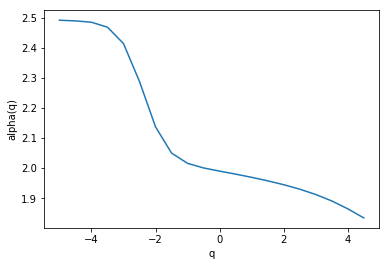

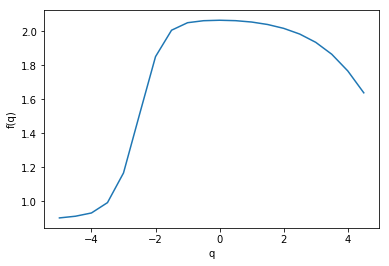

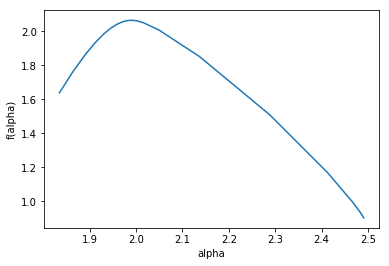


КАНАЛ: B


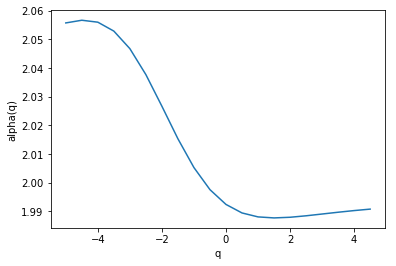

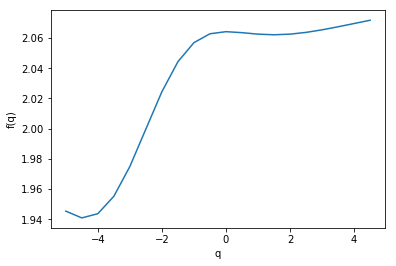

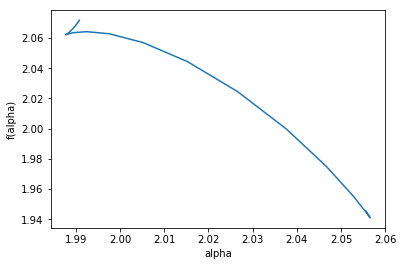


КАНАЛ: G


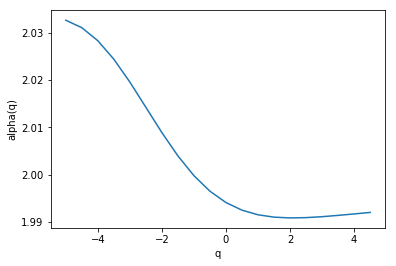

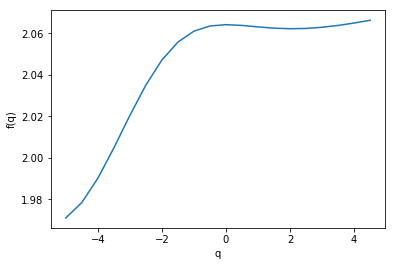

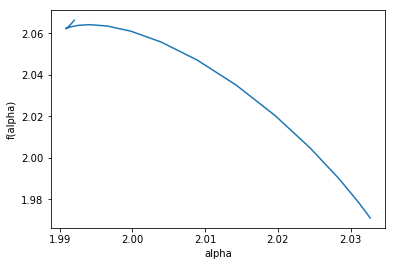


КАНАЛ: R


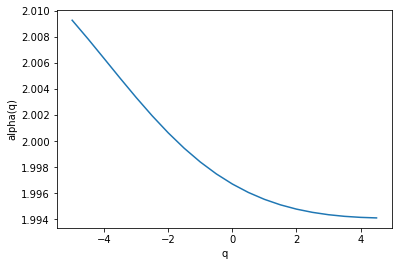

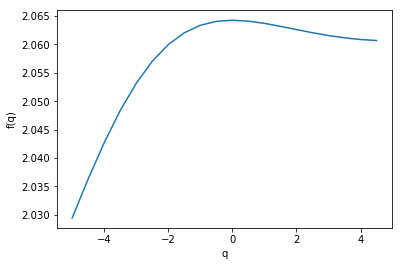

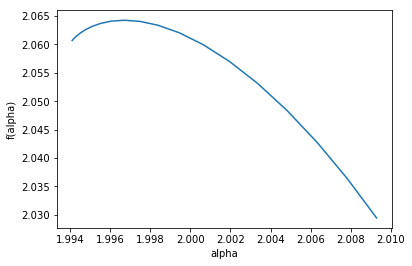





С помощью функции плотности:

КАНАЛ: H


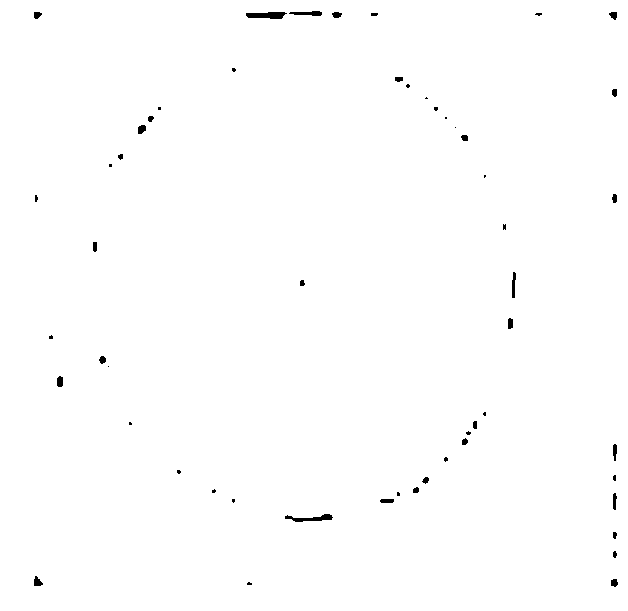

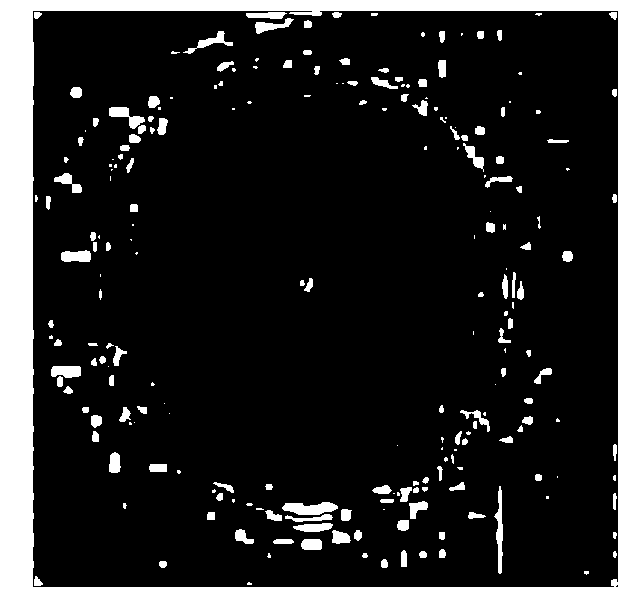

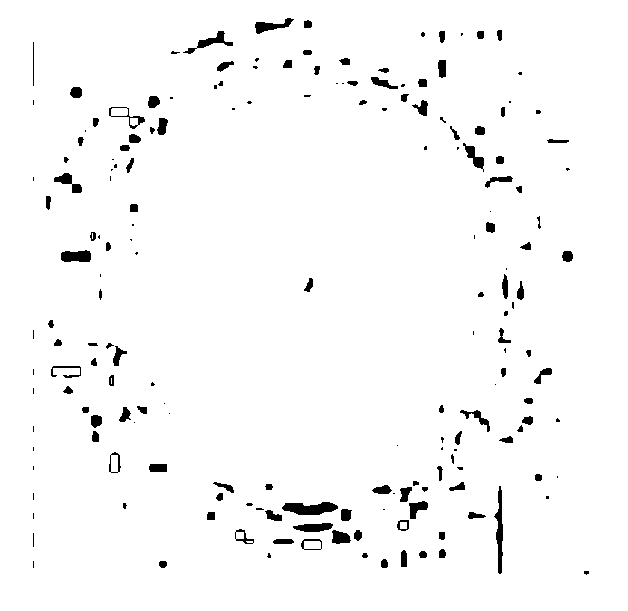

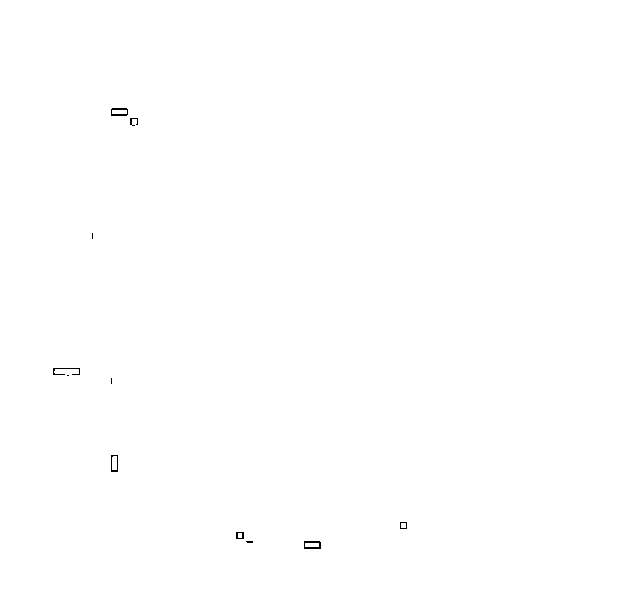

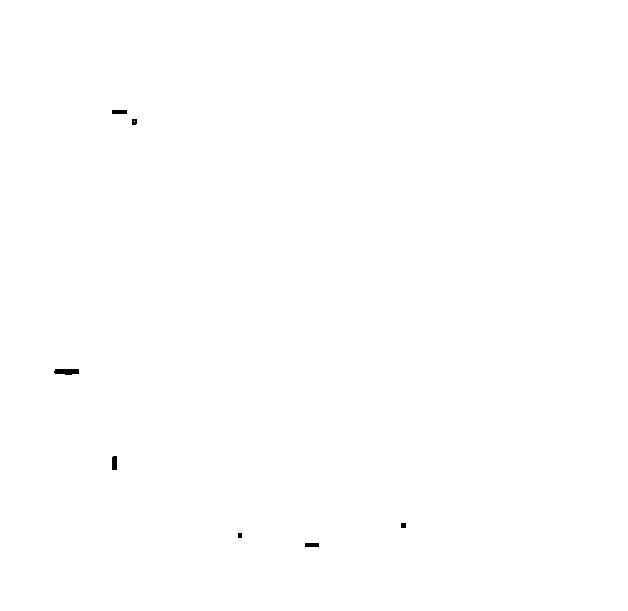

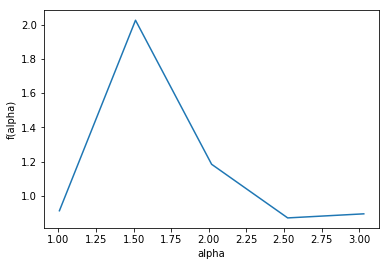


КАНАЛ: B


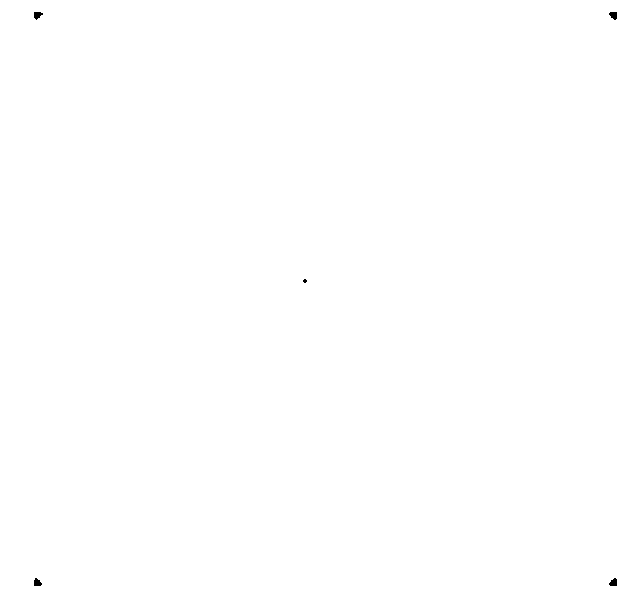

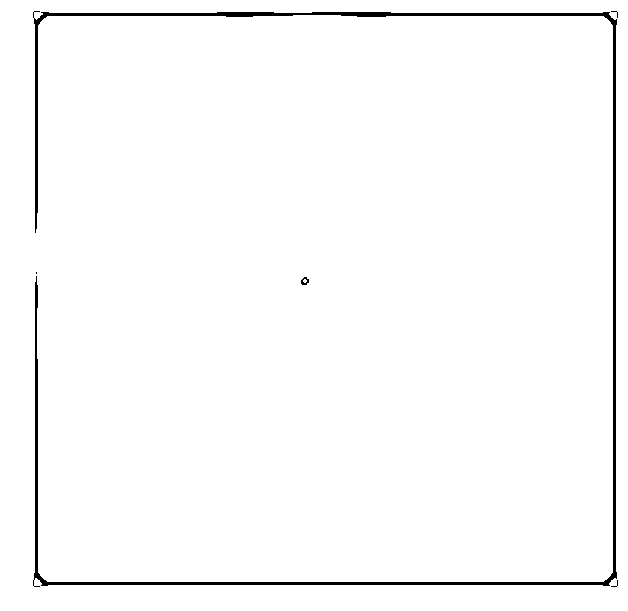

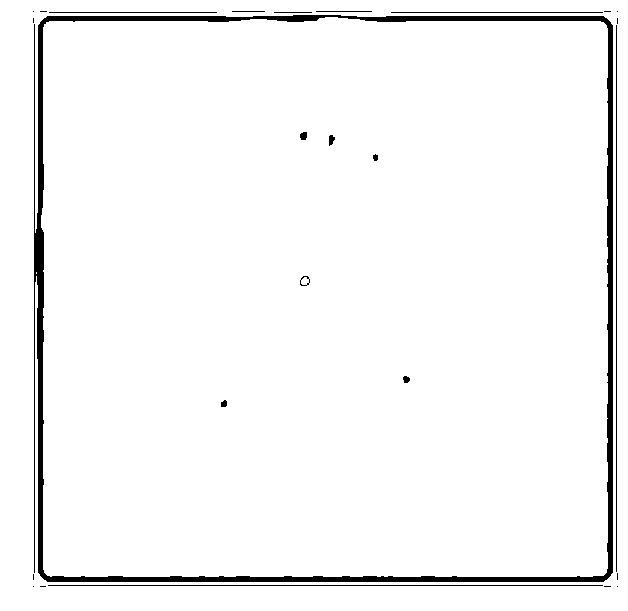

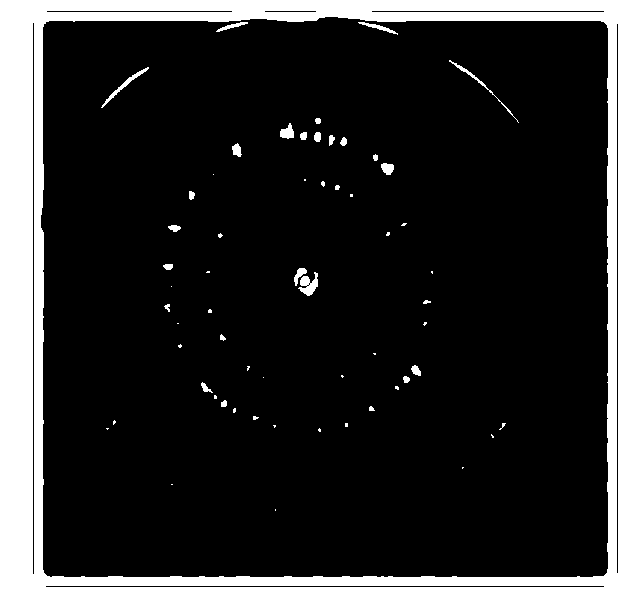

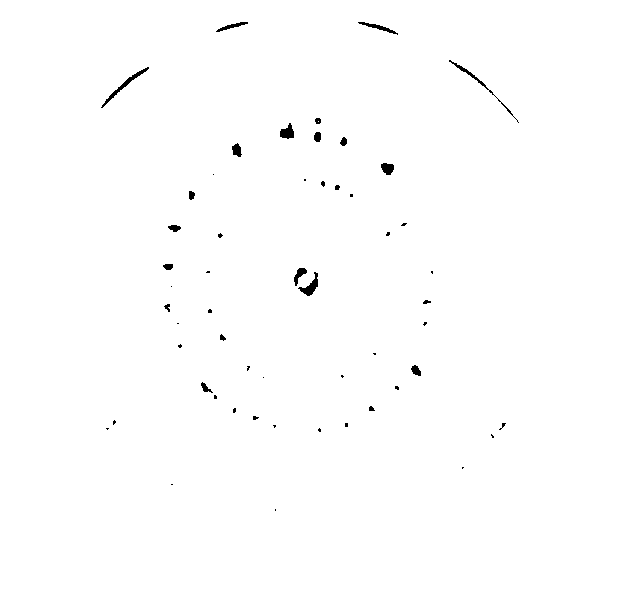

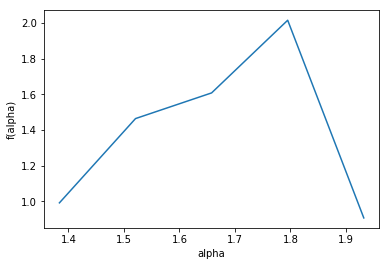


КАНАЛ: G


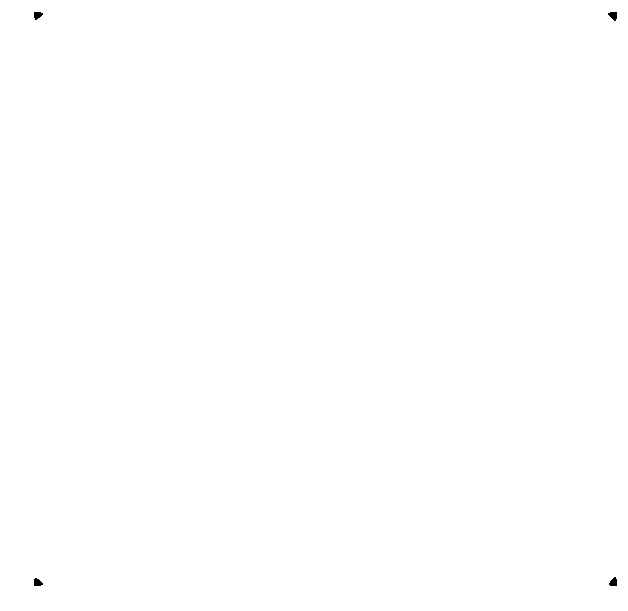

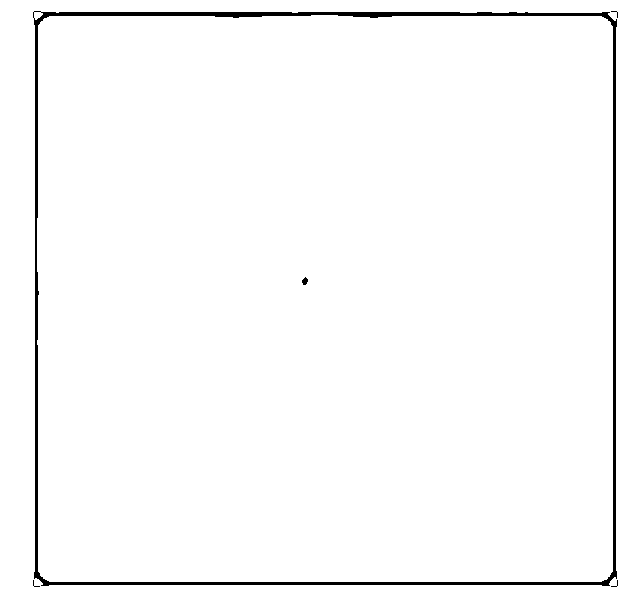

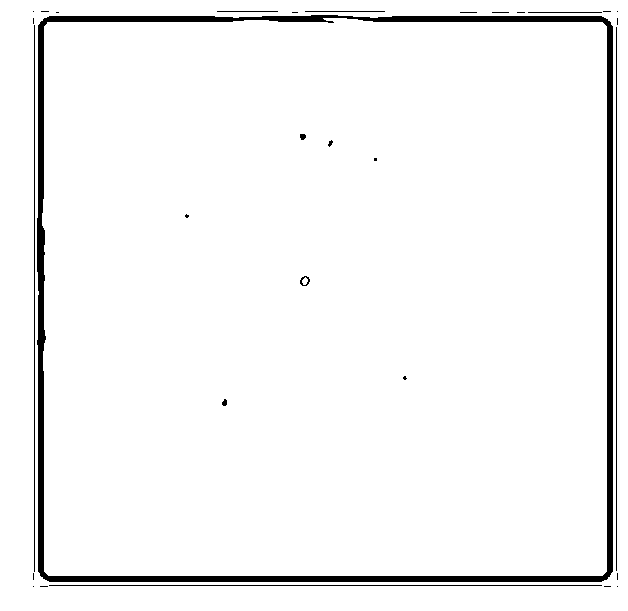

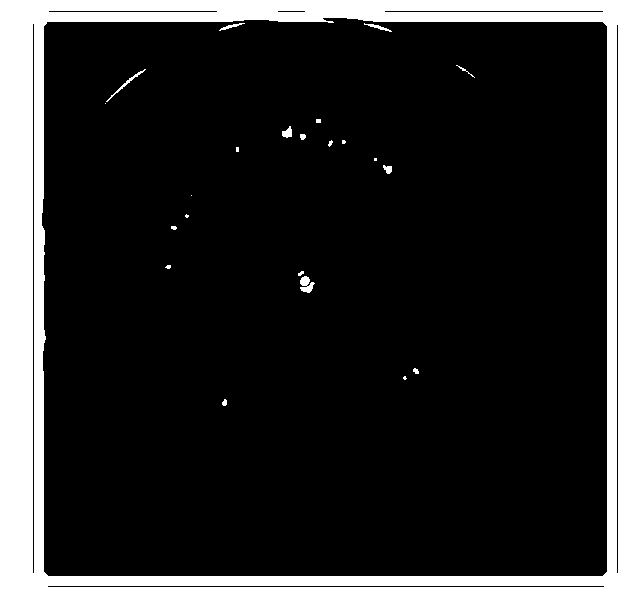

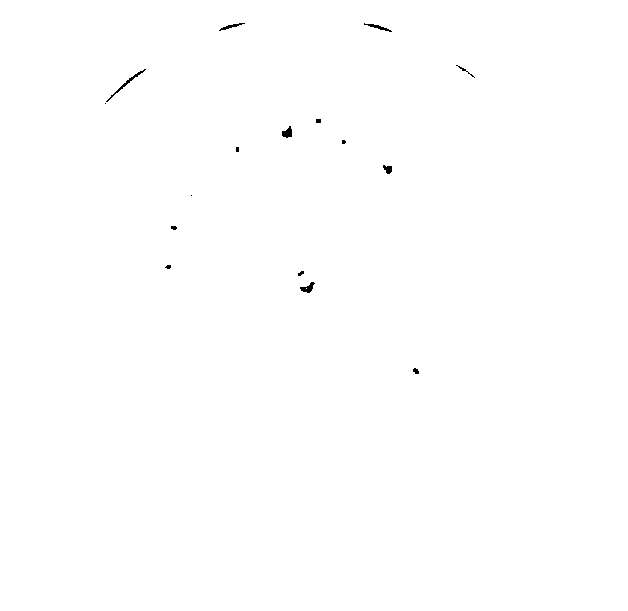

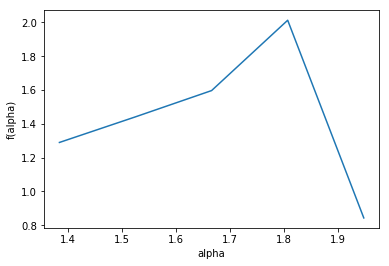


КАНАЛ: R


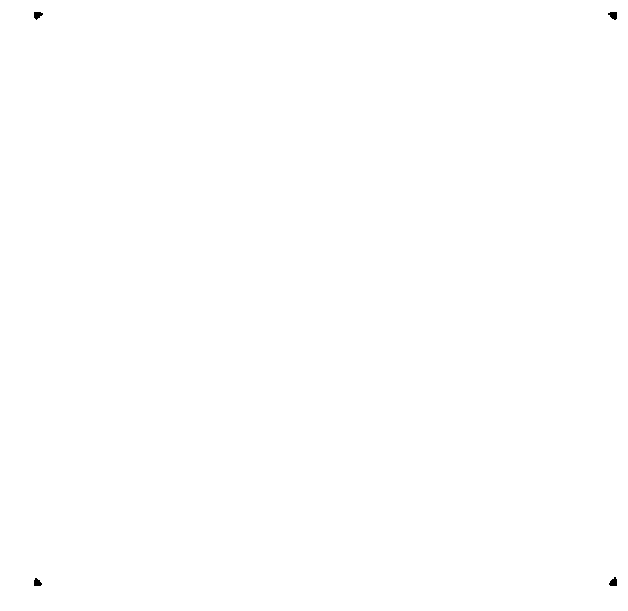

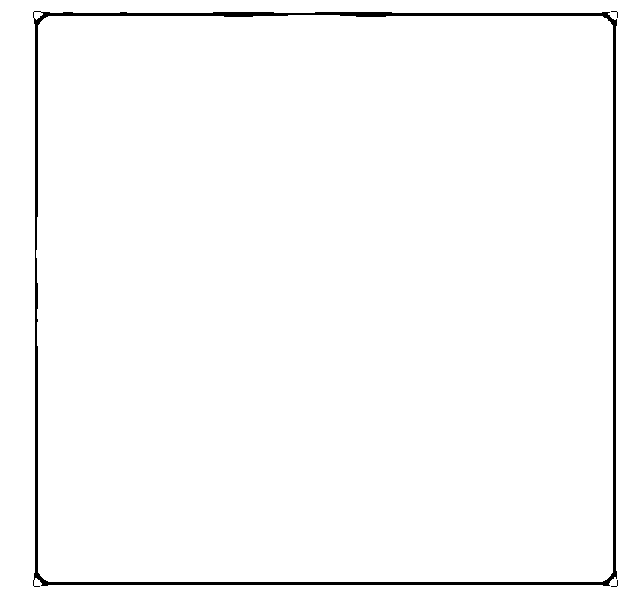

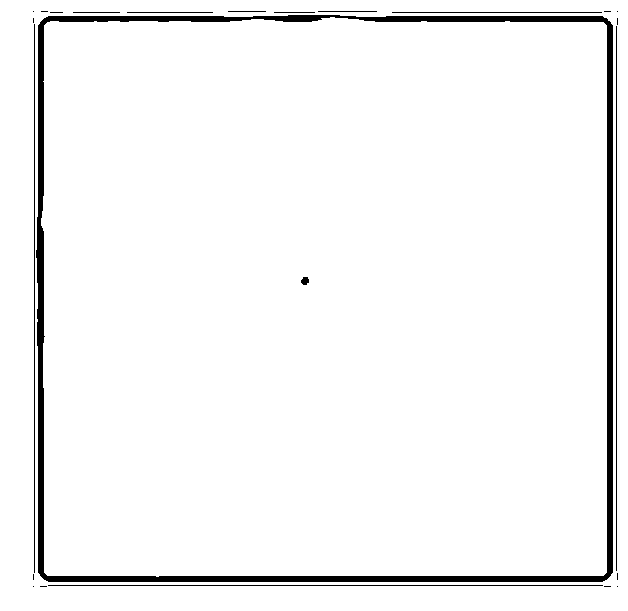

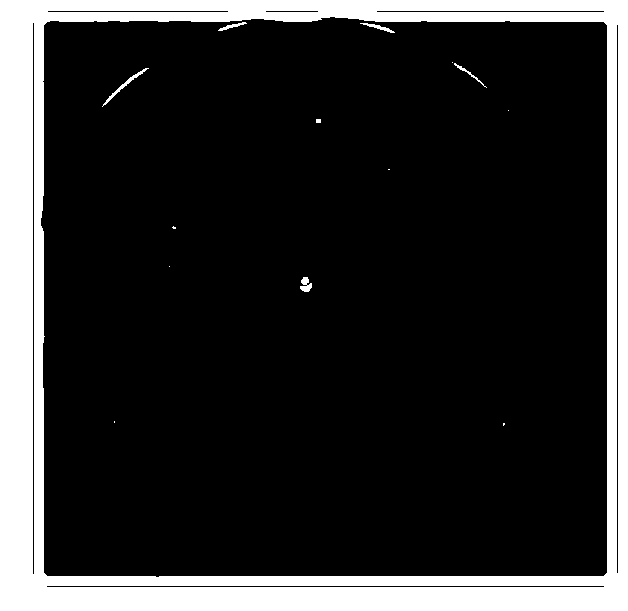

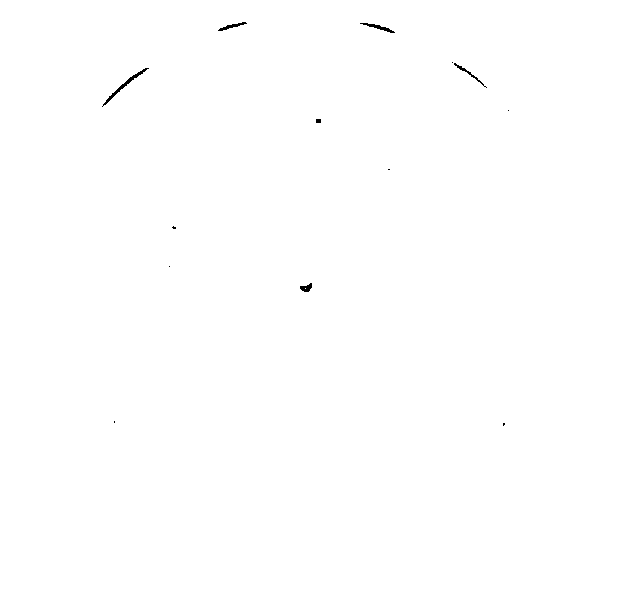

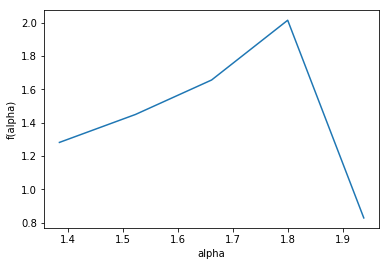

In [2]:
process(image1)

## Второе изображение

С помощью обобщенной статистической суммы:

КАНАЛ: H


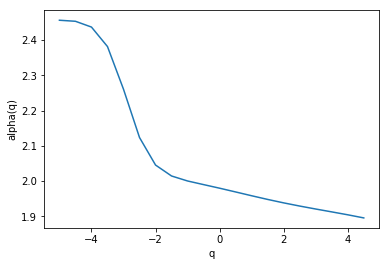

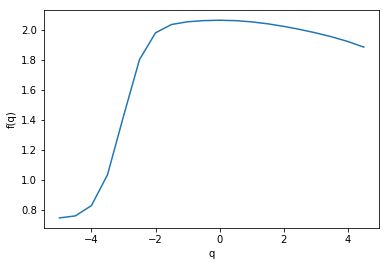

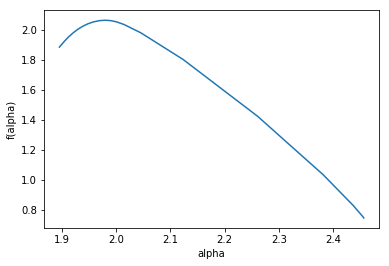


КАНАЛ: B


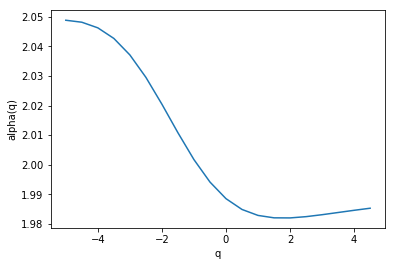

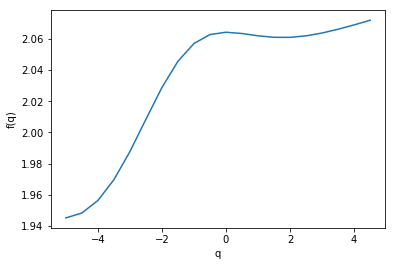

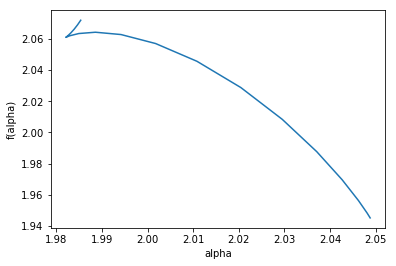


КАНАЛ: G


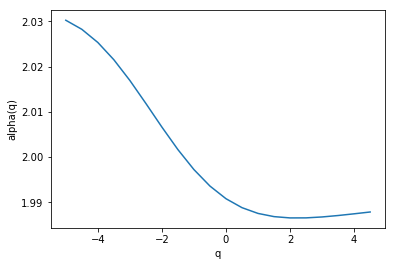

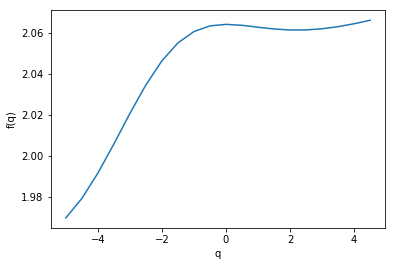

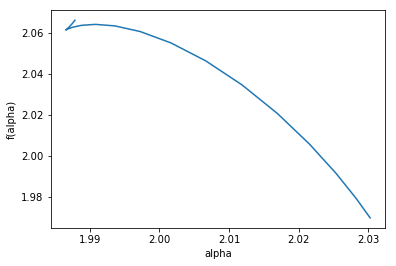


КАНАЛ: R


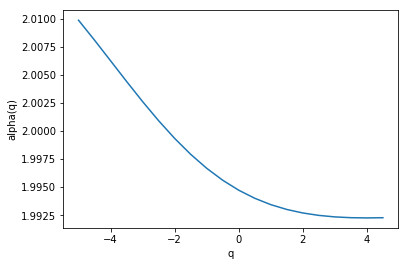

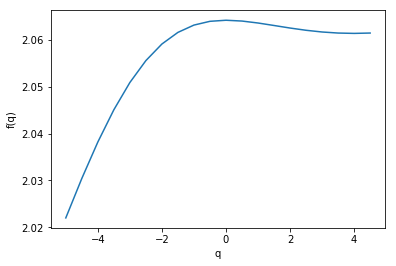

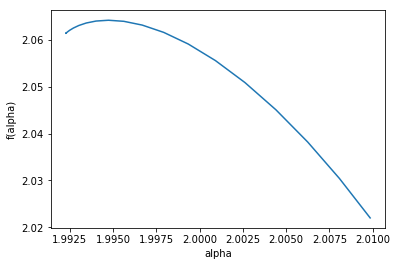





С помощью функции плотности:

КАНАЛ: H


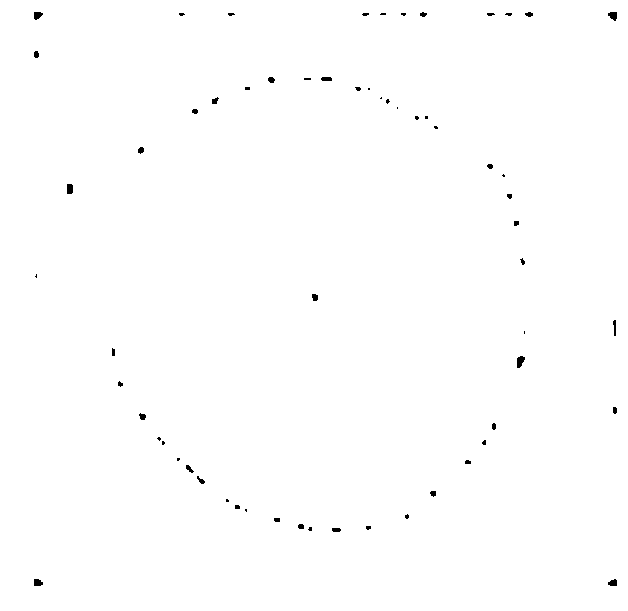

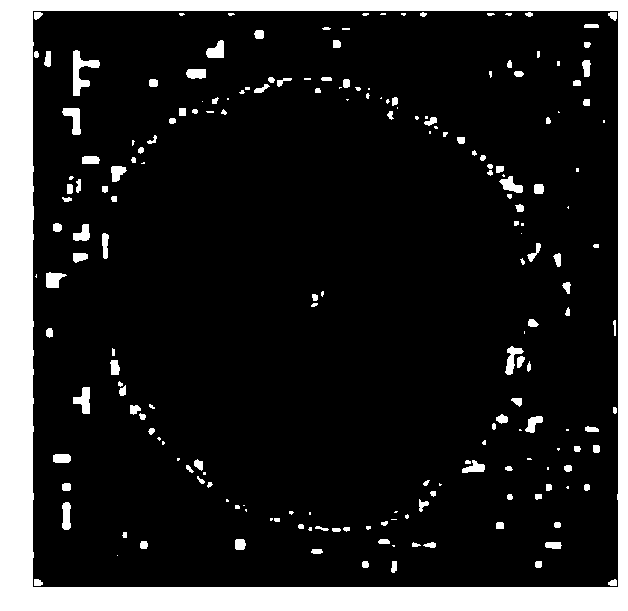

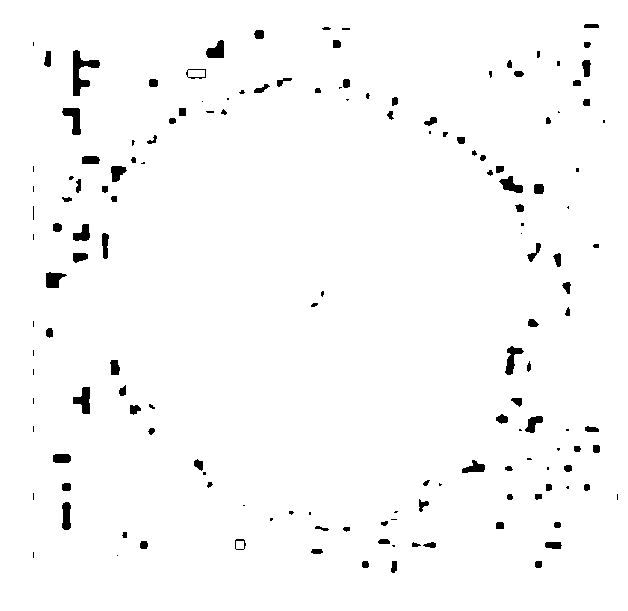

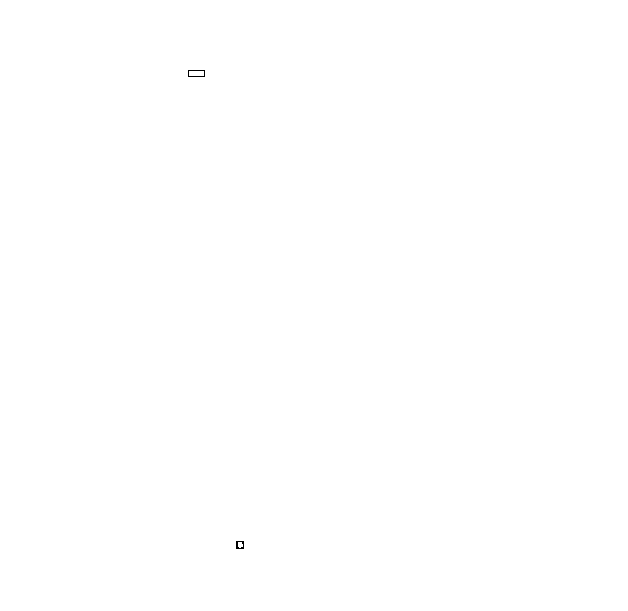

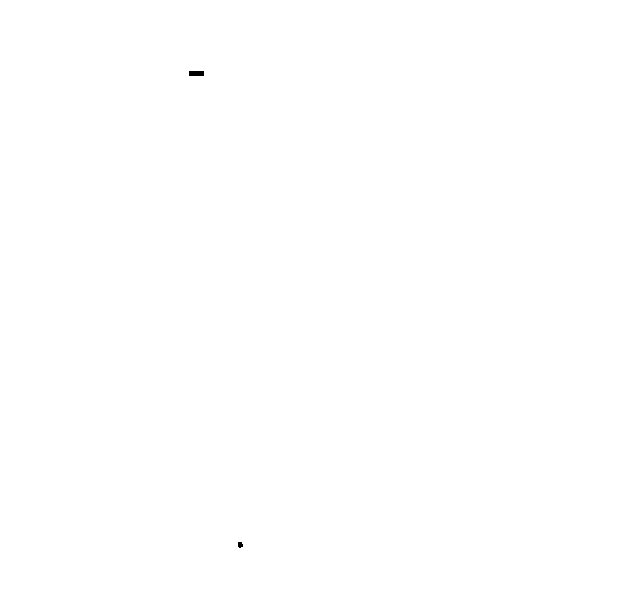

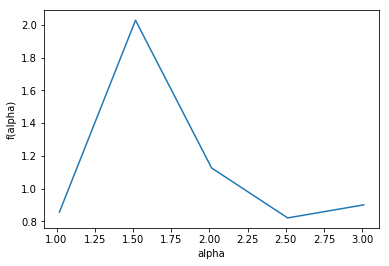


КАНАЛ: B


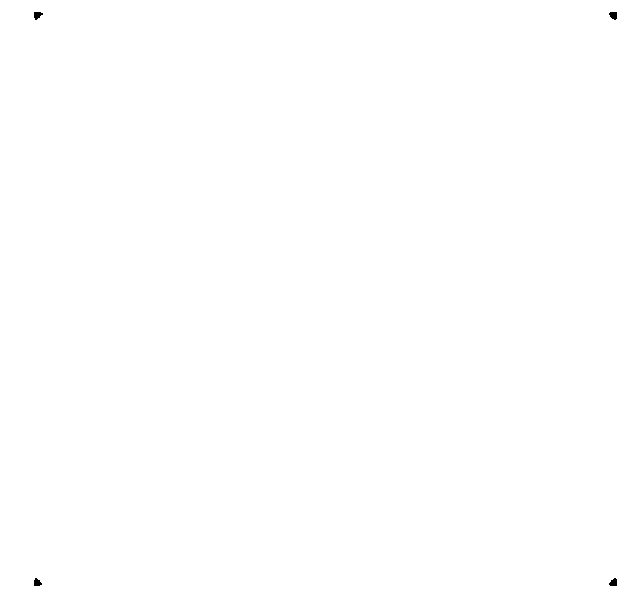

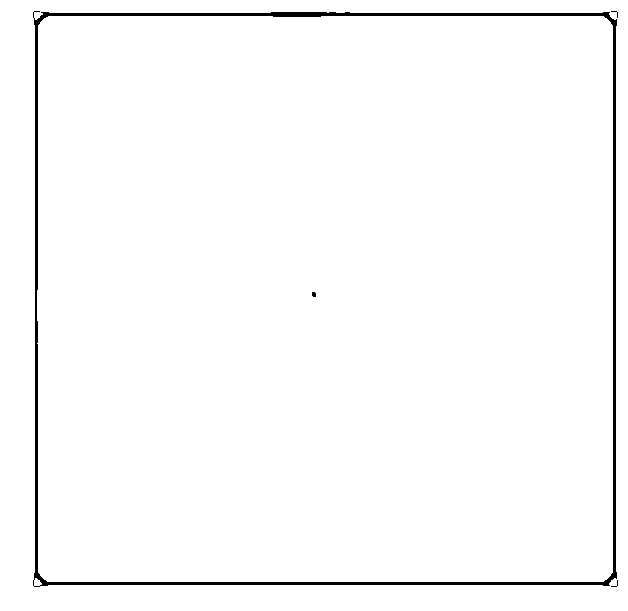

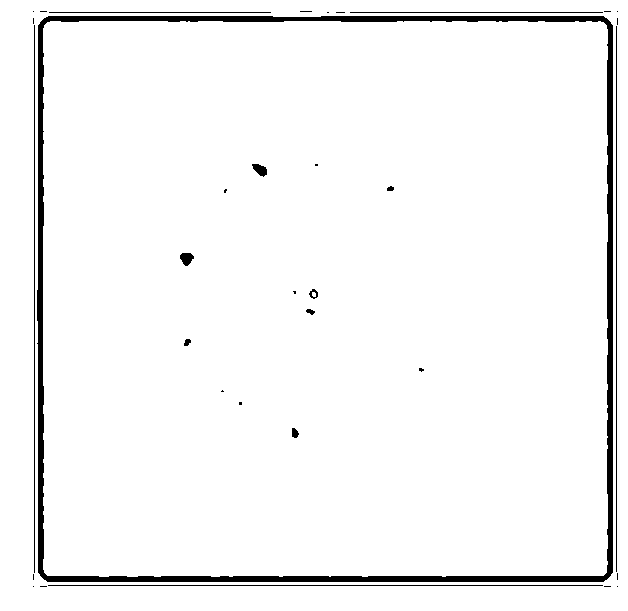

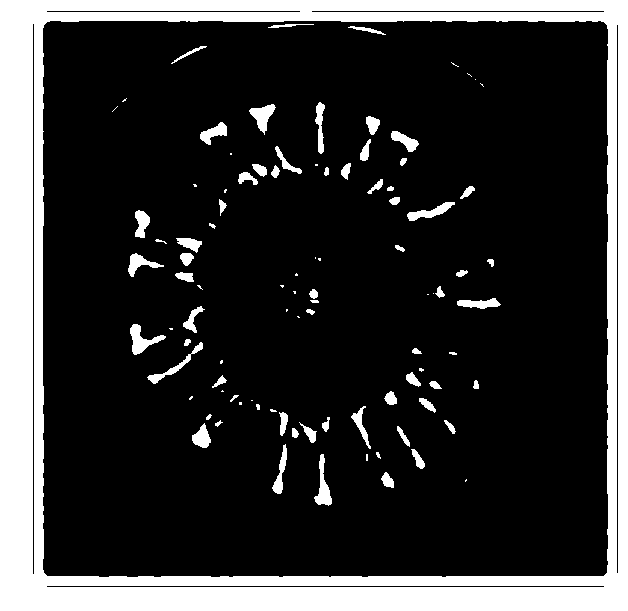

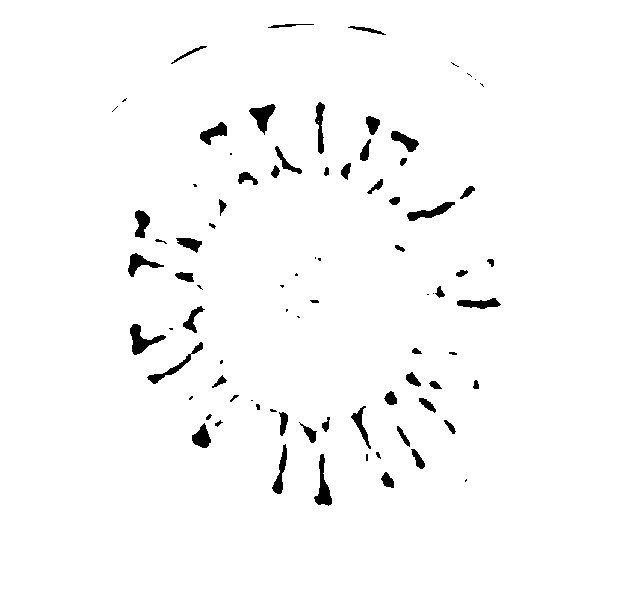

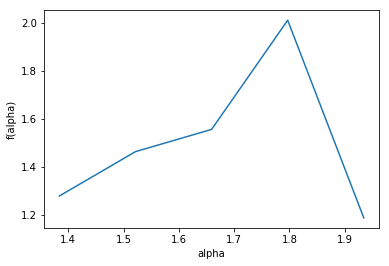


КАНАЛ: G


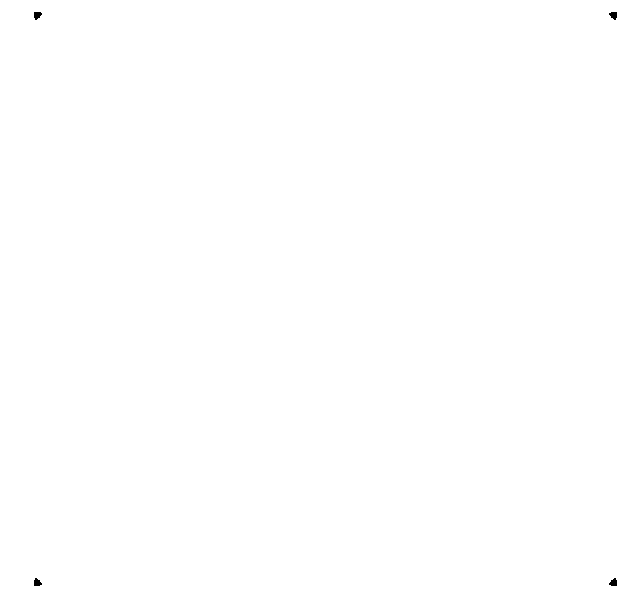

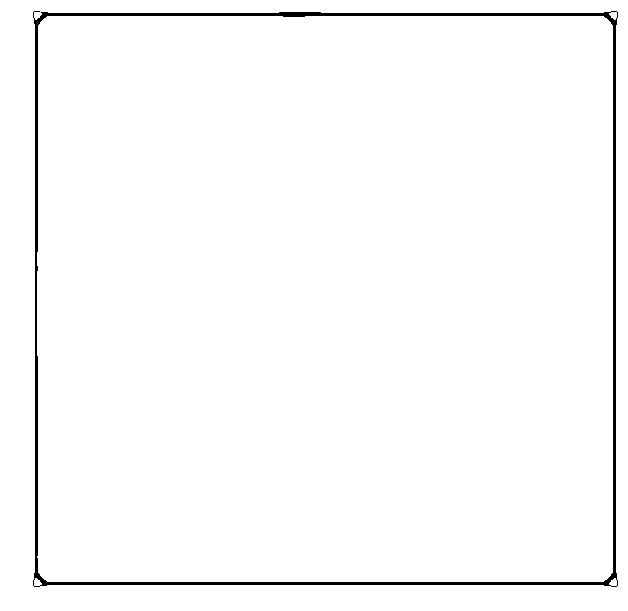

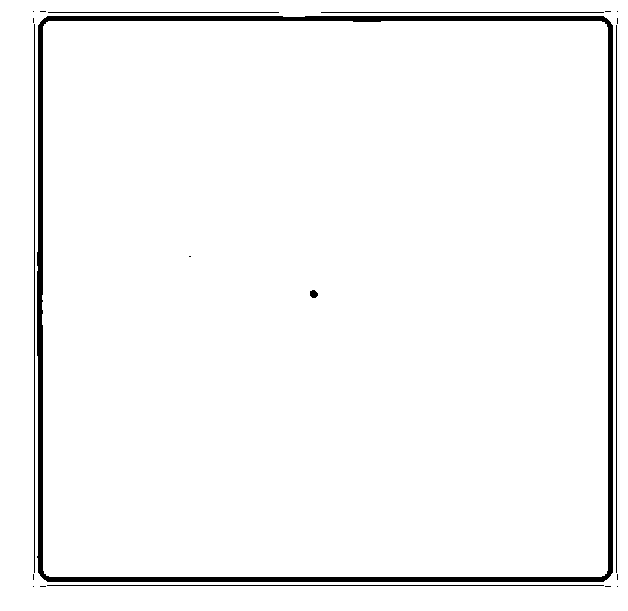

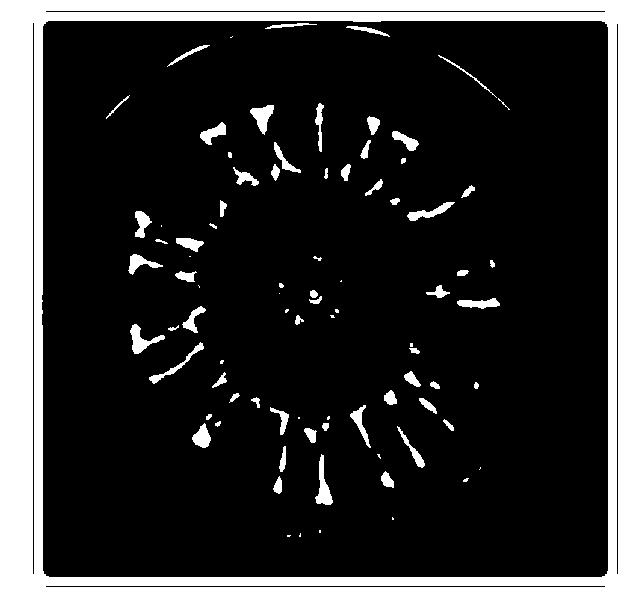

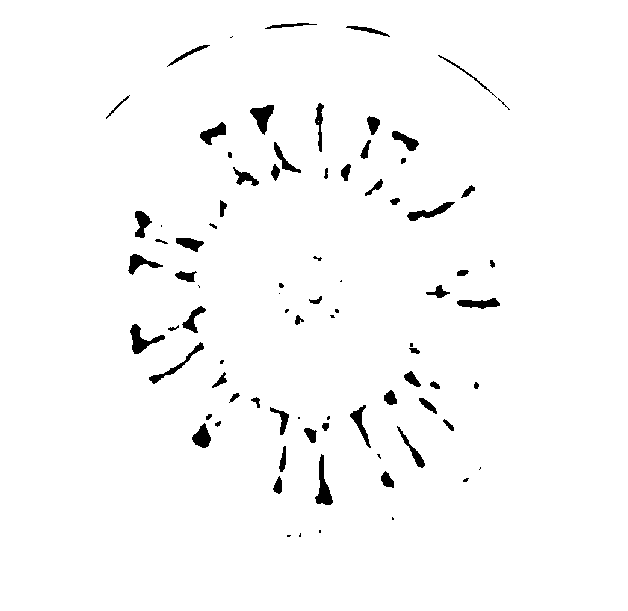

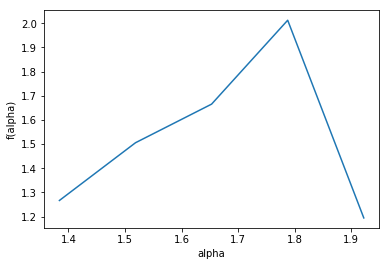


КАНАЛ: R


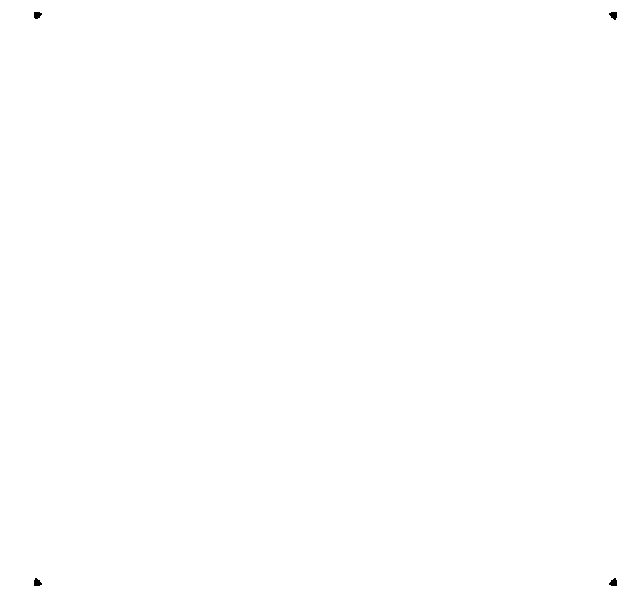

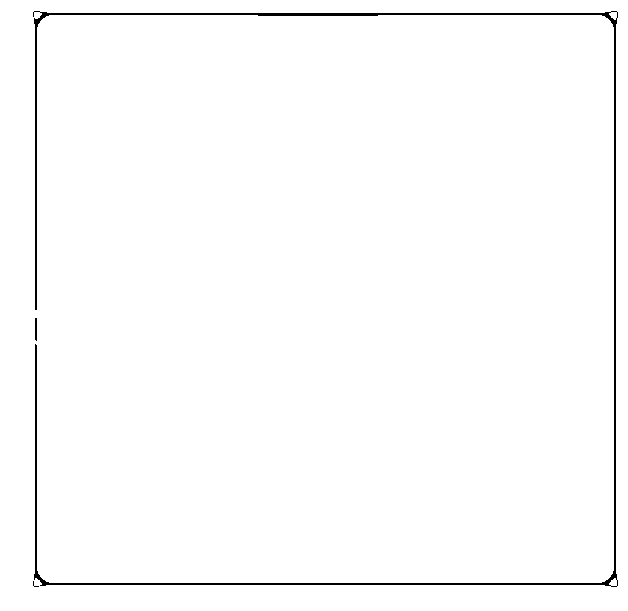

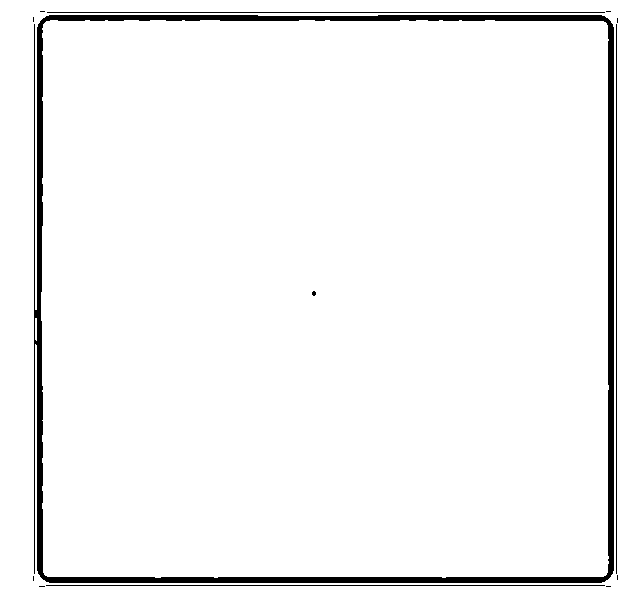

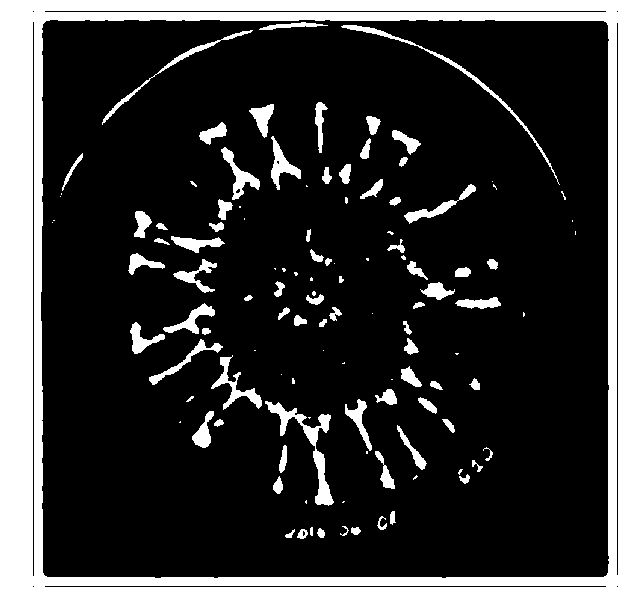

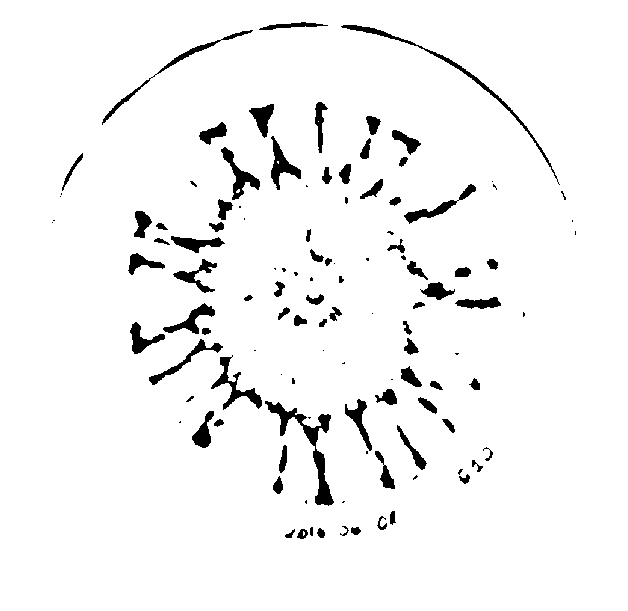

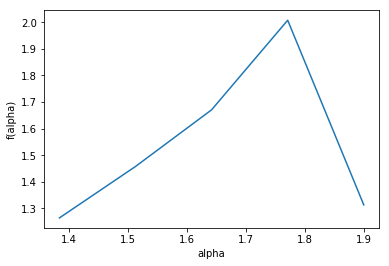

In [3]:
process(image2)

## Третье изображение

С помощью обобщенной статистической суммы:

КАНАЛ: H


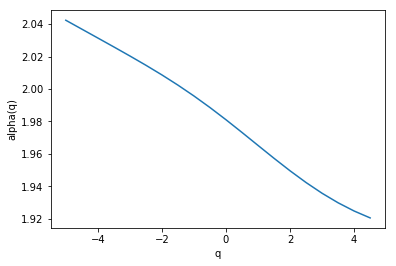

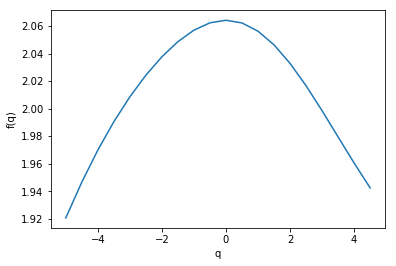

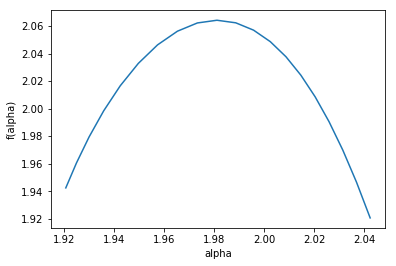


КАНАЛ: B


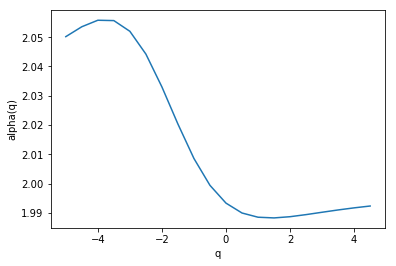

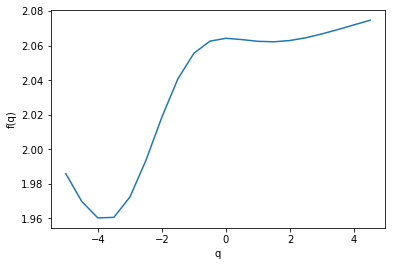

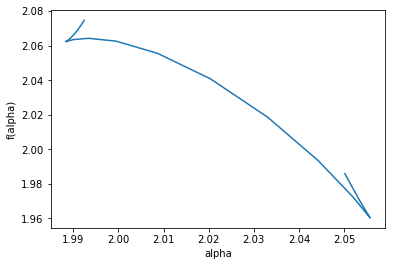


КАНАЛ: G


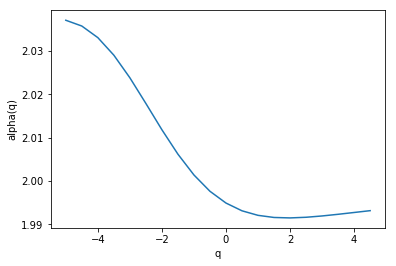

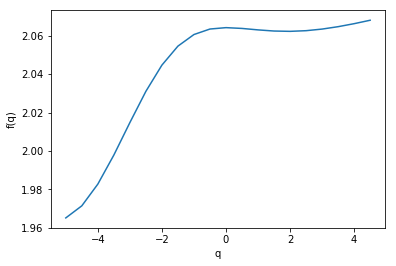

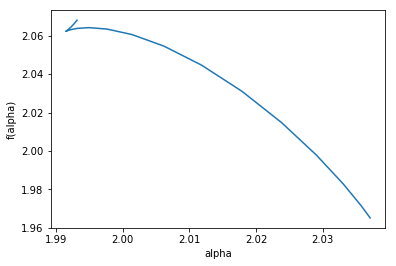


КАНАЛ: R


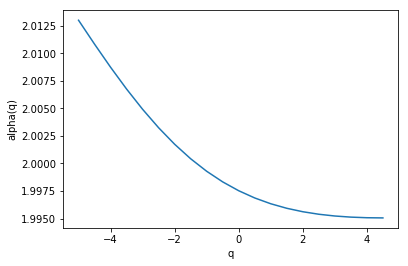

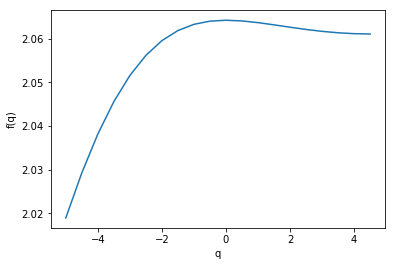

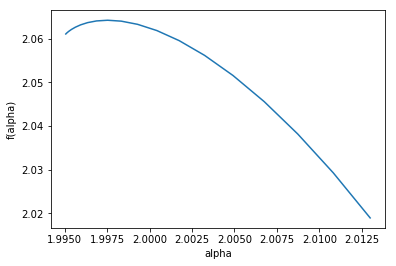





С помощью функции плотности:

КАНАЛ: H


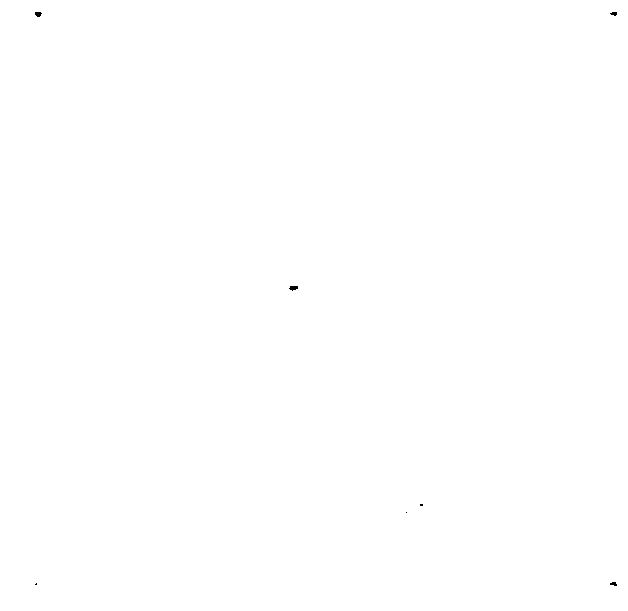

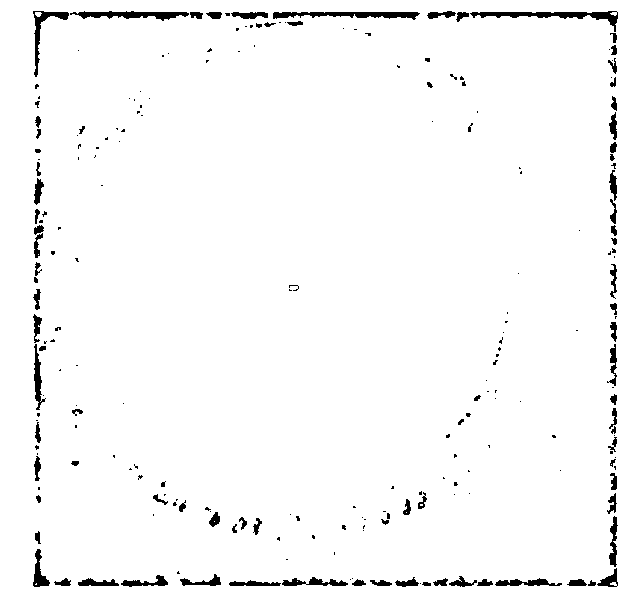

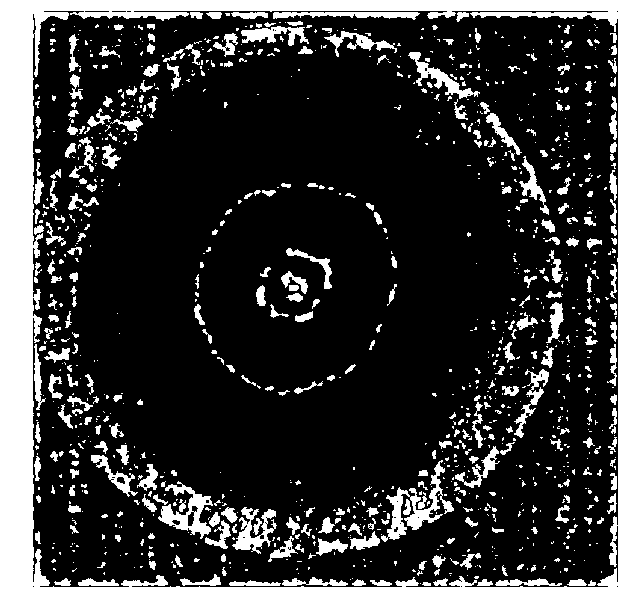

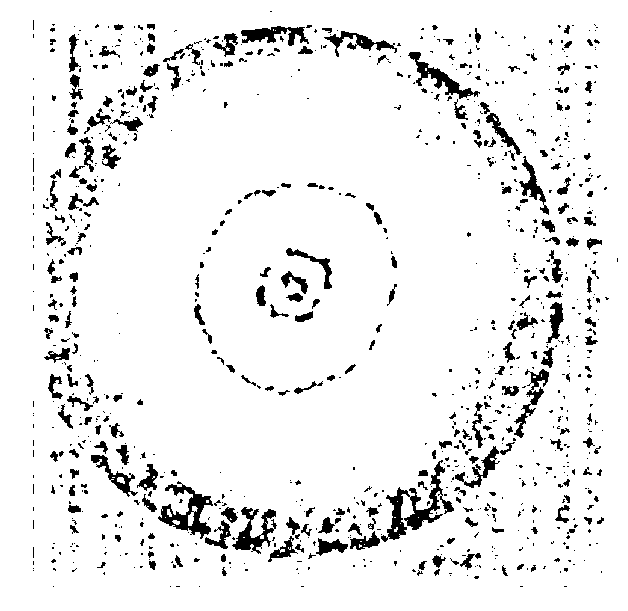

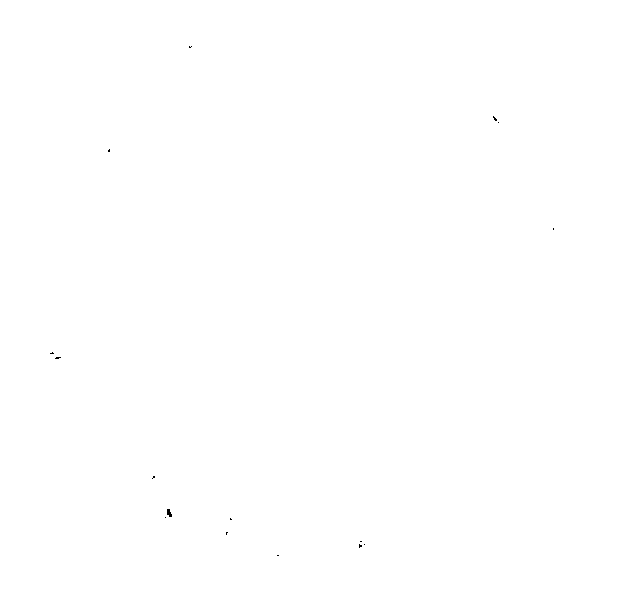

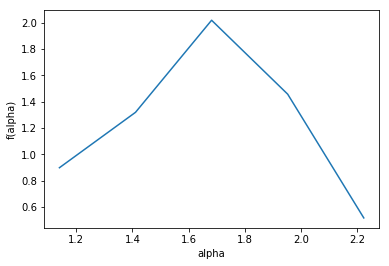


КАНАЛ: B


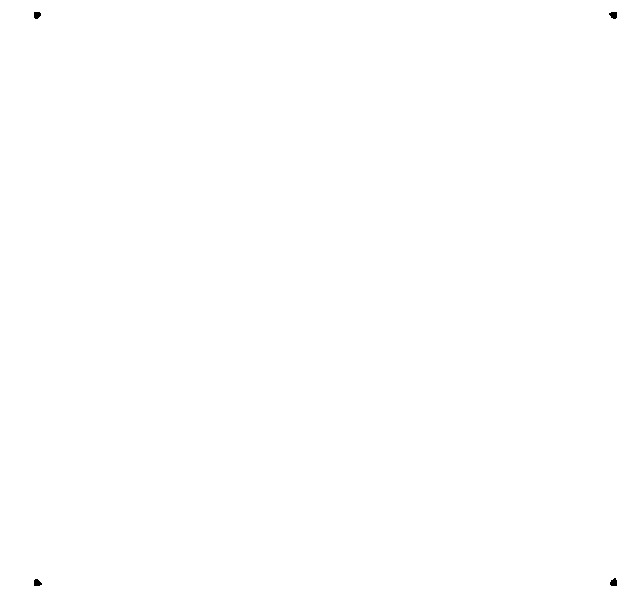

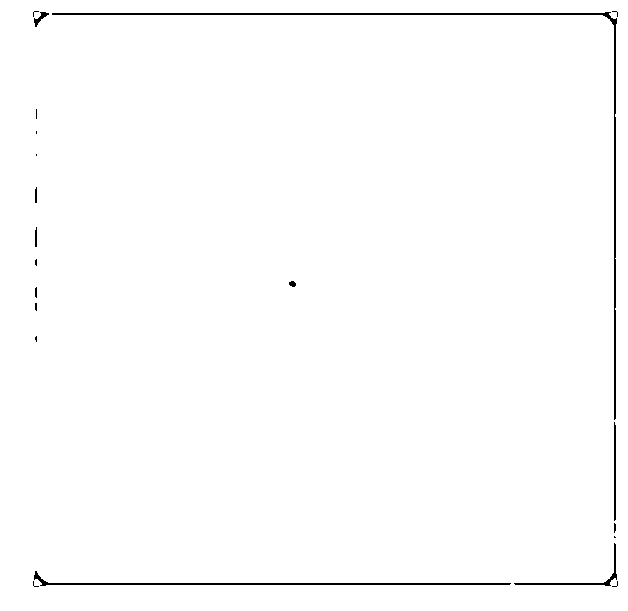

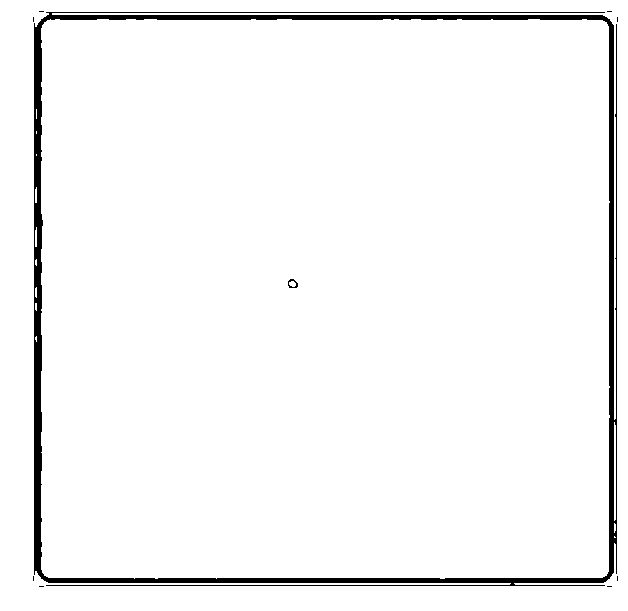

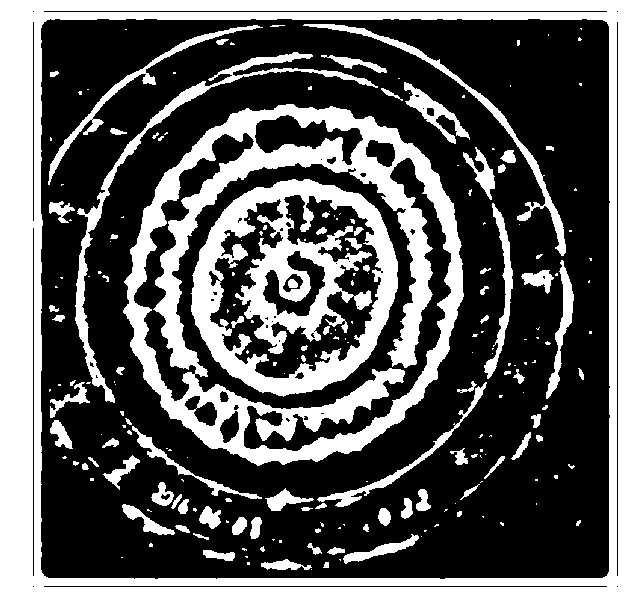

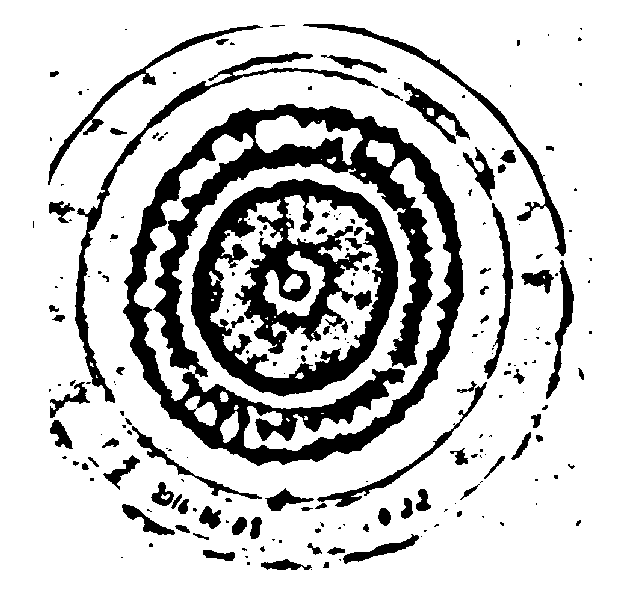

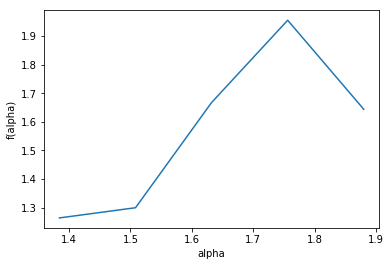


КАНАЛ: G


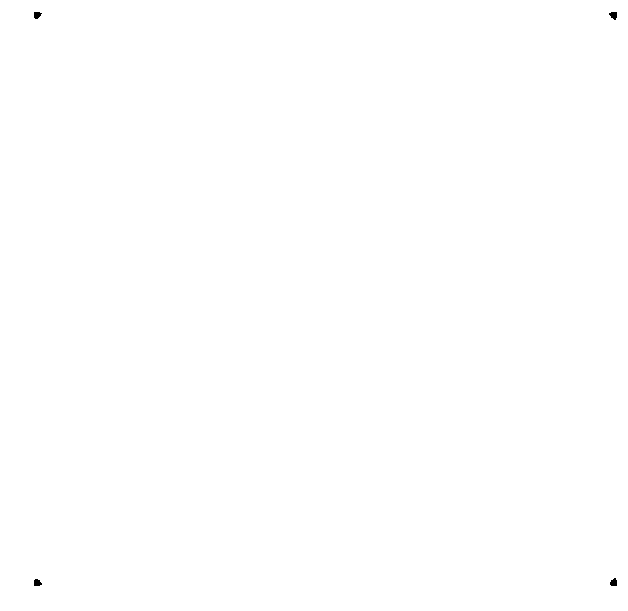

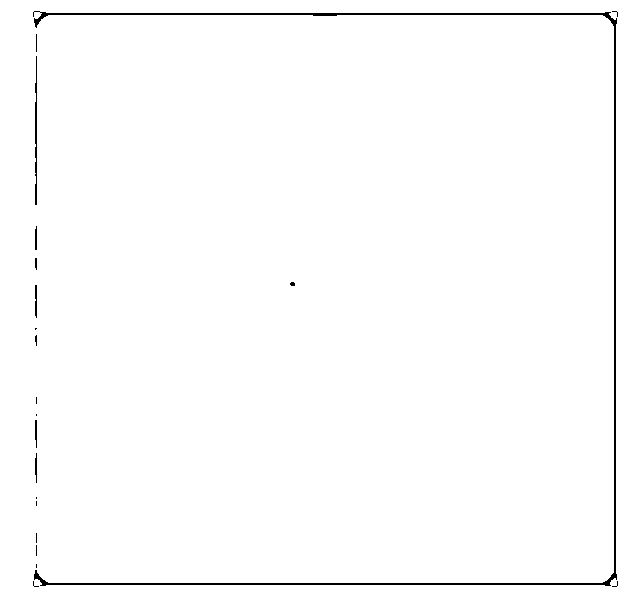

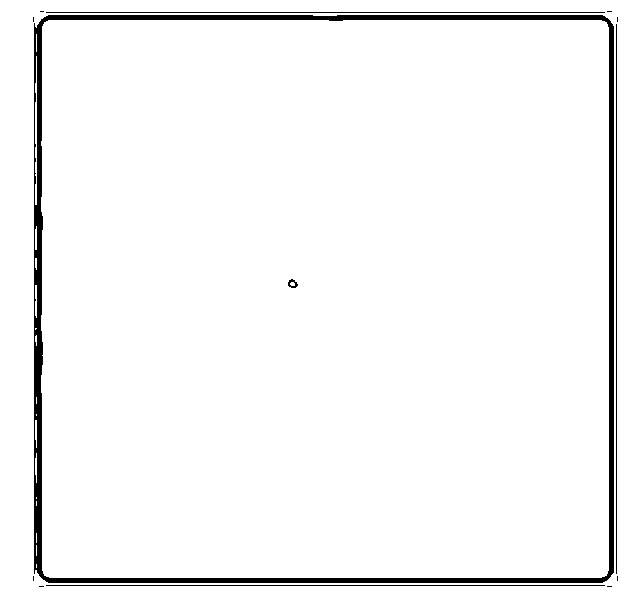

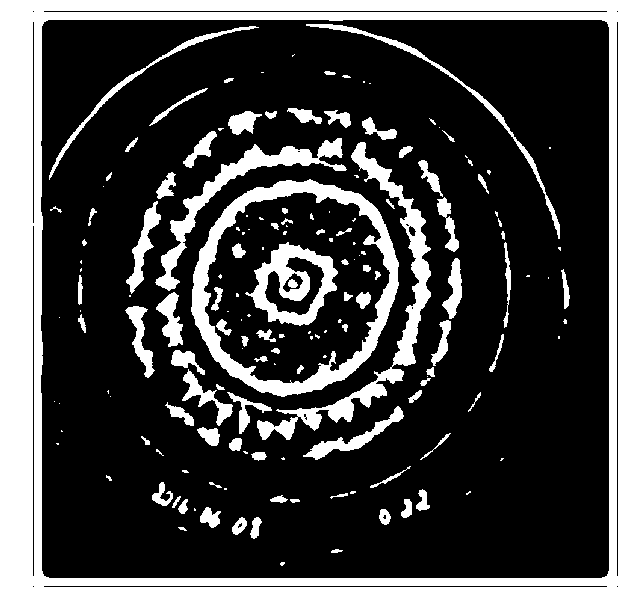

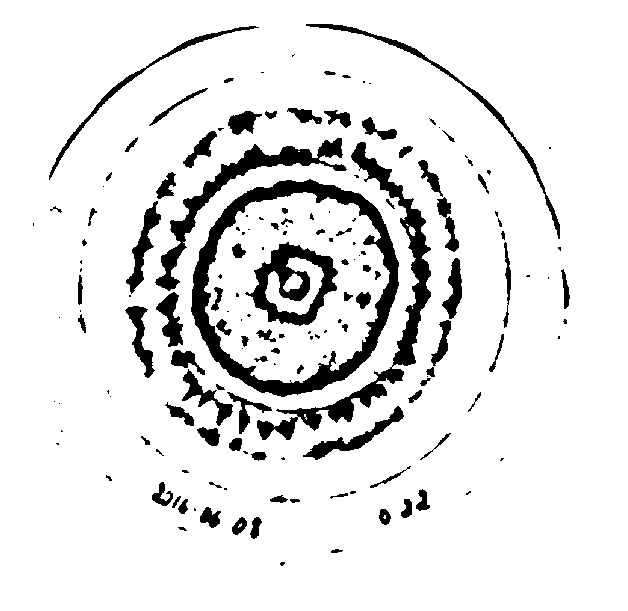

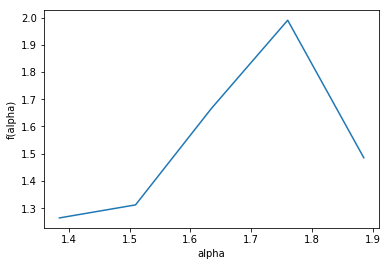


КАНАЛ: R


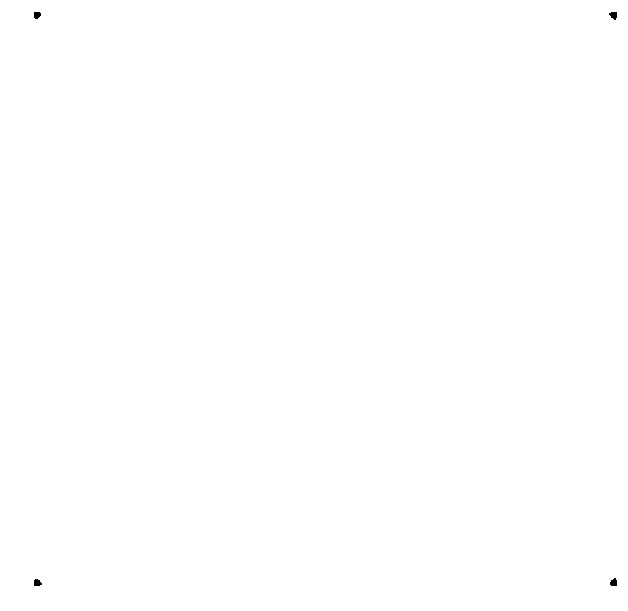

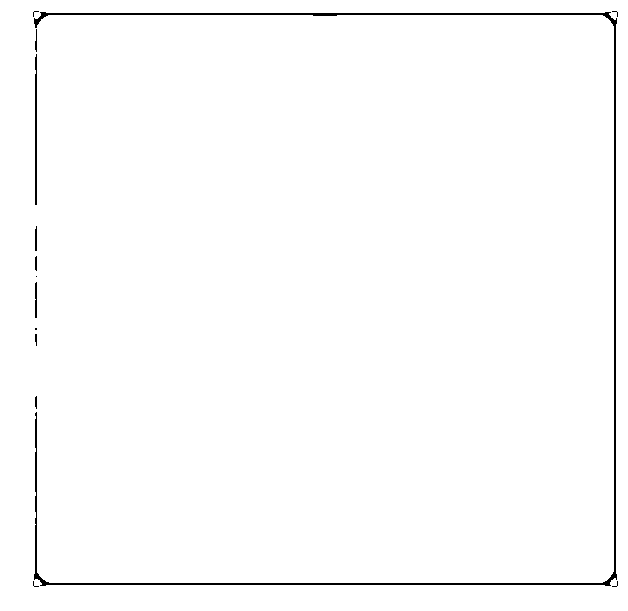

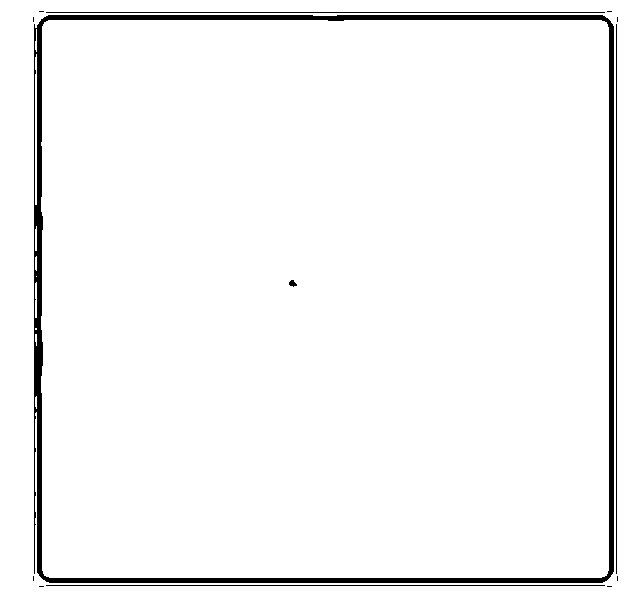

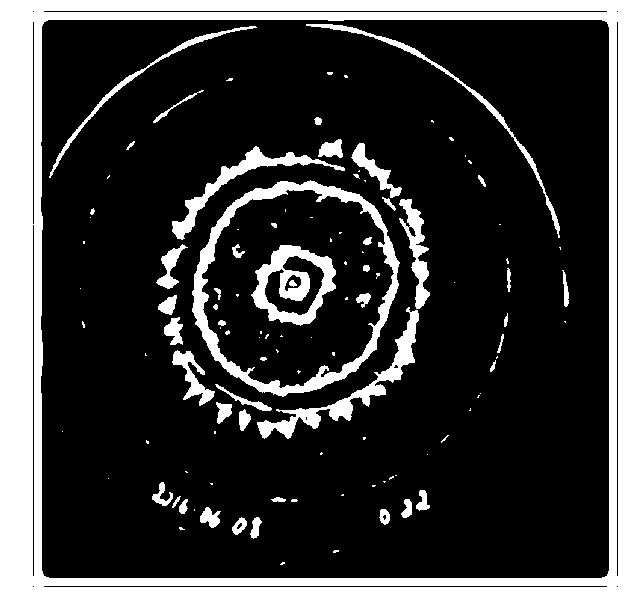

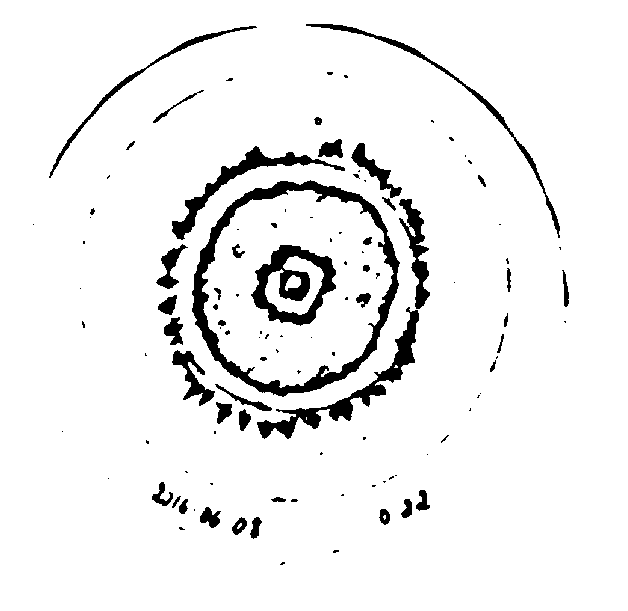

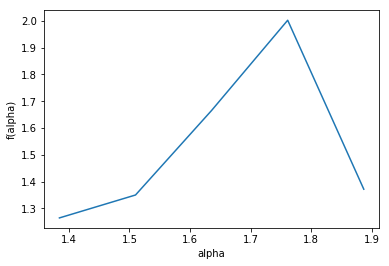

In [8]:
process(image3)